In [1]:
SPECTRUM_FOLDERNAME = 'spectrums_grayscale' # the folder containing the spectrums to load
IMG_HEIGHT = 200
IMG_WIDTH = 500
FILE_SUFFIX = "UPDATED_ARCHITECTURE4"
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10

# Load Data

In [2]:
import pandas as pd

data = pd.read_csv('data_balanced_processed_new.csv', encoding="latin-1")
#data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std,spectrum_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,...,0.056157,5608.665252,2501.480437,4647.658427,941.263597,0.090434,0.124045,0.294583,0.171183,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,...,0.062846,7204.425221,3338.747216,5212.773742,1194.914650,0.148189,0.143111,0.267859,0.234713,drummer1/eval_session/10_soul-groove10_102_bea...
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,...,0.061557,6172.809370,3874.975566,4711.894615,1483.392124,0.116454,0.132516,0.238676,0.153792,drummer1/eval_session/2_funk-groove2_105_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,...,0.053402,5704.099294,3309.100713,5098.568553,1251.293005,0.101191,0.128717,0.149444,0.144291,drummer1/eval_session/3_soul-groove3_86_beat_4...
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,...,0.046688,8042.372855,3504.921958,5396.953176,999.442925,0.181278,0.149775,0.115379,0.128980,drummer1/eval_session/4_soul-groove4_80_beat_4...


# Prepare Data

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
data["encoded_style"] = label_encoder.fit_transform(data.simplified_style)
data.encoded_style.value_counts()

encoded_style
0    200
1    200
4    200
5    200
3    200
2    200
Name: count, dtype: int64

In [4]:
label_encoder.classes_

array(['funk', 'hiphop', 'jazz', 'latin', 'pop', 'rock'], dtype=object)

Because we sampled some audio files multiple times. We should prevent data leakage between train and test/validation sets. We do this by using the group shuffle split from scikit-learn. This messes up the distribution of genres a bit though. To find the best split, that has no data leakage and a good distribution of genres, we will use the forbidden technique of random state hacking! We are using it to create a good split and not to overfit the model, so it is fine i think.
We just check the genre distributions produced by different random states and choose the one, that differs the least from a perfectly balanced distributon.

In [5]:
from sklearn.model_selection import GroupShuffleSplit
group_shuffle_rnd_state = 8698

In [6]:
# prevent data leakage by grouping splits by audio_filename
groups = data['audio_filename']
gss = GroupShuffleSplit(n_splits=5, train_size=0.7, random_state=group_shuffle_rnd_state)
for train_indices, remaining_indices in gss.split(X=data, groups=groups):
    #GroupShuffleSplit.split() returns a tuple instead of Numpy.nparray when used outside of a for loop somehow. So I guess I need to fill this loop with code...
    useless_variable = None


# create dataframe from group split indices and shuffle the train dataframe
data_train = data.iloc[train_indices].sample(frac=1.0, random_state=42)
remaining_data = data.iloc[remaining_indices]

# check for data leakage
print('Data leakage =', data_train['audio_filename'].isin(remaining_data['audio_filename']).any())

# check genre distribution
print("\nTrain data genre distribution")
print(data_train.simplified_style.value_counts(normalize=True))

print("\nRemaining data genre distribution")
print(remaining_data.simplified_style.value_counts(normalize=True))

Data leakage = False

Train data genre distribution
simplified_style
latin     0.169082
rock      0.167874
funk      0.167874
hiphop    0.166667
jazz      0.166667
pop       0.161836
Name: proportion, dtype: float64

Remaining data genre distribution
simplified_style
pop       0.177419
jazz      0.166667
hiphop    0.166667
funk      0.163978
rock      0.163978
latin     0.161290
Name: proportion, dtype: float64


In [7]:
from sklearn.model_selection import train_test_split

# # split the remaining data into test and validation data sets. No need to worry about data leakage, because these datasets are not used for training.
data_test, data_validation = train_test_split(remaining_data, test_size=0.5, random_state=42,)
data_test.shape

# check the distribution after the split
print(data_train.shape, data_test.shape, data_validation.shape, )
print("Train data share: ", data_train.shape[0] / data.shape[0])
print("Validation data share: ", data_validation.shape[0]/ data.shape[0])
print("Test data share: ", data_test.shape[0] / data.shape[0])

(828, 43) (186, 43) (186, 43)
Train data share:  0.69
Validation data share:  0.155
Test data share:  0.155


# CNN Predictions

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

path_images = os.path.join('..', 'Datasets', SPECTRUM_FOLDERNAME)

BATCH_SIZE = 32

# Normalize images and add the custom preprocessing function
image_generator = ImageDataGenerator(
    rescale=1.0/255,
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=data_test,
    directory=path_images,
    x_col="spectrum_filename",
    y_col="simplified_style",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="grayscale", #add color mode,
    shuffle=False,  # this is crucial for later evaluation!
)

Found 186 validated image filenames belonging to 6 classes.


In [10]:
from tensorflow.keras.models import load_model

model_path = os.path.join('..', 'data', 'models', 'multiclass_cnn_UPDATED_ARCHITECTURE4.keras')
cnn_model = load_model(model_path, compile=False)

cnn_probabilities = cnn_model.predict(test_generator, verbose=1)
cnn_probabilities.shape

6/6 [==============================] - 4604s 789s/step


(186, 6)

In [51]:
pd.DataFrame(cnn_probabilities).to_csv('cnn_test_probabilities_UPDATED_ARCHITECTURE4.csv', index=False)

# Random Forest Predictions

In [24]:
import pickle

def load_model(model):
    path_data = os.path.join('..', 'data', 'models')
    filepath = os.path.join(path_data, model)

    with open(filepath, 'rb') as model:
        rnd_forest = pickle.load(model)
    
    return rnd_forest

def random_forest_predict(X, model ='RANDOM_FOREST_Extracted_BPM_full_file_model.pkl'):
    print("Calculating random forest predictions...")
    rnd_forest = load_model(model)
    X = X.drop(columns=['melspectogram'])
    return rnd_forest.predict_proba(X)

In [28]:
X = data_test.drop(columns=["drummer", "session", "id", 'beat_type', "midi_filename", "audio_filename", "style", "simplified_style", "encoded_style", "split", "spectrum_filename"])
X = X.drop(columns=["time_signature"])
X = X.drop(columns=["duration", "start", "end", "times_sampled", "oversampling_ratio", "possible_samples"])
X = X.drop(columns=['bpm', 'onset_strengths', 'onset_frames'])

rf_propabilities = random_forest_predict(X)
rf_propabilities.shape

Calculating random forest predictions...


(186, 6)

# Final Predictions

In [48]:
import numpy as np

probs = rf_propabilities + cnn_probabilities
probs.shape

(186, 6)

# Evaluation

In [40]:
import numpy as np

# Convert predictions to class indices (if using softmax output)
predicted_classes = np.argmax(probs, axis=1)

# True labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get the class labels

In [45]:
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

FILE_SUFFIX = "FINAL_MODEL"

def evaluate_model(true_classes, predicted_classes):
    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("Classification Report:\n", report)

    # Hamming Loss
    h_loss = hamming_loss(true_classes, predicted_classes)
    print("Hamming Loss:", h_loss)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return report, h_loss

In [46]:
# Convert the classification report to a markdown table
def convert_to_markdown(report, hamming_loss, image_path=None, file_suffix=FILE_SUFFIX):
    lines = report.strip().split('\n')
    headers = lines[0].split()
    table = "| " + " | ".join(headers) + " |\n"
    table += "| " + " | ".join(['---'] * len(headers)) + " |\n"
    
    for line in lines[1:]:
        row = " | ".join(line.split())
        table += "| " + row + " |\n"
    
    markdown_content = f"# Classification Report for {file_suffix}\n\n"
    markdown_content += f"__Hamming Loss__ = {hamming_loss}\n\n{table}\n"
    
    if image_path:
        markdown_content += f"\n![Image]({image_path})\n"
    
    return markdown_content

def save_evaluation(report, h_loss, file_suffix=FILE_SUFFIX):
    eval_path = os.path.join('..', 'evaluation')
    conf_matrix_path = os.path.join(eval_path, 'images', 'confusion_matrix_' + file_suffix + '.png')
    markdwon_path = os.path.join(eval_path, 'markdown', 'classification_report_' + file_suffix + '.md')
    plt.savefig(conf_matrix_path)
    #plt.close()

    # Generate markdown content
    markdown_content = convert_to_markdown(report, h_loss, conf_matrix_path, file_suffix=file_suffix)

    # Write to a markdown file
    with open(markdwon_path, "w") as file:
        file.write(markdown_content)

Classification Report:
               precision    recall  f1-score   support

        funk       0.54      0.54      0.54        28
      hiphop       0.53      0.47      0.50        36
        jazz       0.67      0.28      0.39        29
       latin       0.46      0.78      0.58        27
         pop       0.38      0.31      0.34        36
        rock       0.41      0.53      0.46        30

    accuracy                           0.47       186
   macro avg       0.50      0.48      0.47       186
weighted avg       0.49      0.47      0.46       186

Hamming Loss: 0.5268817204301075


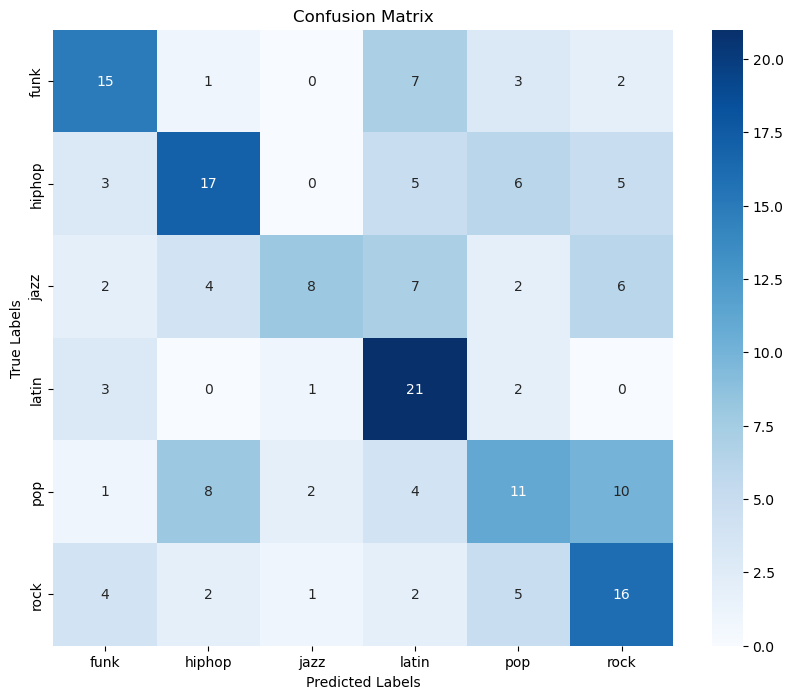

<Figure size 640x480 with 0 Axes>

In [47]:
report, h_loss = evaluate_model(true_classes, predicted_classes)
save_evaluation(report, h_loss)